In [28]:
import pandas as pd
import numpy as np
import math

def redondear_a_primera_cifra_diferente_de_cero(numero):
    if numero == 0:
        return 0.0

    # Calcula el signo del número
    signo = -1 if numero < 0 else 1

    # Convierte el número a su valor absoluto
    numero_abs = abs(numero)

    # Encuentra el exponente en notación científica (potencia de 10)
    exponente = int(math.floor(math.log10(numero_abs)))

    # Calcula la cifra más significativa
    cifra_mas_significativa = int(numero_abs / 10 ** exponente)

    # Calcula el número redondeado
    numero_redondeado = signo * cifra_mas_significativa * 10 ** exponente

    return numero_redondeado

# Crear una lista de valores de corriente y período
corriente = [1.0, 1.5, 2, 2.5, 3, 3.5, 4]  # Ejemplo: reemplaza con tus datos reales
periodo = [10.9, 6.9, 4.8, 3.6, 3.1, 2.8, 2.5]      # Ejemplo: reemplaza con tus datos reales

# Definir las incertidumbres
incertidumbre_corriente = 0.05  # ±0.05 I
incertidumbre_periodo = 0.1    # ±0.1 s

# Crear un DataFrame
data = {
    'Corriente (I)': corriente,
    'Incertidumbre en Corriente': [incertidumbre_corriente] * len(corriente),
    'Periodo (T)': periodo,
    'Incertidumbre en Periodo': [incertidumbre_periodo] * len(periodo)
}

df = pd.DataFrame(data)

df

,Corriente (I),Incertidumbre en Corriente,Periodo (T),Incertidumbre en Periodo
0,1.0,0.05,10.9,0.1
1,1.5,0.05,6.9,0.1
2,2.0,0.05,4.8,0.1
3,2.5,0.05,3.6,0.1
4,3.0,0.05,3.1,0.1
5,3.5,0.05,2.8,0.1
6,4.0,0.05,2.5,0.1


In [44]:
constante_magnetica = 1.36e-3  # T/A

# Calcular el campo magnético
df['Campo Magnético (B)'] = constante_magnetica * df['Corriente (I)']

# Calcular la incertidumbre en el campo magnético
df['Incertidumbre en B'] = abs(constante_magnetica) * df['Incertidumbre en Corriente']

df['Incertidumbre en B']=df['Incertidumbre en B'].apply(redondear_a_primera_cifra_diferente_de_cero)

# Calcular la frecuencia omega
df['Frecuencia (omega)'] = 2 * np.pi / df['Periodo (T)']

# Calcular la incertidumbre en omega
df['Incertidumbre en omega'] = abs(-2 * np.pi / (df['Periodo (T)'] ** 2)) * df['Incertidumbre en Periodo']

df['Incertidumbre en omega'] = df['Incertidumbre en omega'].apply(redondear_a_primera_cifra_diferente_de_cero)


In [45]:
df

,Corriente (I),Incertidumbre en Corriente,Periodo (T),Incertidumbre en Periodo,Campo Magnético (B),Incertidumbre en B,Frecuencia (omega),Incertidumbre en omega
0,1.0,0.05,10.9,0.1,0.00136,0.00006,0.576439,0.005
1,1.5,0.05,6.9,0.1,0.00204,0.00006,0.910607,0.010
2,2.0,0.05,4.8,0.1,0.00272,0.00006,1.308997,0.020
3,2.5,0.05,3.6,0.1,0.00340,0.00006,1.745329,0.040
4,3.0,0.05,3.1,0.1,0.00408,0.00006,2.026834,0.060
5,3.5,0.05,2.8,0.1,0.00476,0.00006,2.243995,0.080
6,4.0,0.05,2.5,0.1,0.00544,0.00006,2.513274,0.100


In [40]:
redondear_a_primera_cifra_diferente_de_cero(df['Incertidumbre en omega'][6])

0.1

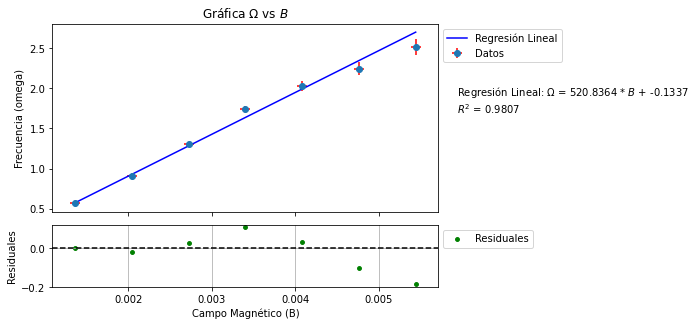

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Supongamos que ya tienes un DataFrame llamado 'df' con las columnas de B, Incertidumbre en B, omega y Incertidumbre en omega.

# Crear los arrays de datos
x = df['Campo Magnético (B)'].values
y = df['Frecuencia (omega)'].values
incertidumbre_x = df['Incertidumbre en B'].values
incertidumbre_y = df['Incertidumbre en omega'].values

# Calcular los pesos como el inverso del cuadrado de las incertidumbres
pesos = 1 / (incertidumbre_y ** 2)

# Definir la función de la regresión lineal ponderada
def regresion_lineal_ponderada(x, m, b):
    return m * x + b

# Realizar el ajuste de la regresión lineal ponderada
params, cov_matrix = curve_fit(regresion_lineal_ponderada, x, y, sigma=incertidumbre_y, absolute_sigma=True)

# Los parámetros resultantes son m (pendiente) y b (ordenada al origen)
pendiente = params[0]
ordenada_al_origen = params[1]

# Calcular la matriz de covarianza de los parámetros
covarianza_pendiente = cov_matrix[0, 0]
covarianza_ordenada_al_origen = cov_matrix[1, 1]

# Calcular la incertidumbre en la pendiente
incertidumbre_pendiente = np.sqrt(covarianza_pendiente)

# Calcular los valores ajustados
y_pred = regresion_lineal_ponderada(x, pendiente, ordenada_al_origen)

# Calcular los residuales
residuales = y - y_pred

# Calcular el coeficiente de determinación (R^2)
r_squared = 1 - (np.sum(residuales**2) / ((len(y) - 1) * np.var(y, ddof=1)))

# Crear la figura y los ejes con dos subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 5), sharex=True,
                               gridspec_kw={'height_ratios': [3, 1]})  # Ajustar la relación de altura

# Gráfica de la regresión lineal
ax1.errorbar(x, y, xerr=incertidumbre_x, yerr=incertidumbre_y,
             fmt='o', label='Datos', ecolor='red')
ax1.plot(x, y_pred, color='blue', label='Regresión Lineal')
ax1.set_ylabel('Frecuencia (omega)')
ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Título de la gráfica
ax1.set_title('Gráfica $\\Omega$ vs $B$')

# Gráfica de los residuales
ax2.scatter(x, residuales, color='green', marker='o', s=15, label='Residuales')
ax2.axhline(y=0, color='black', linestyle='--')
ax2.set_xlabel('Campo Magnético (B)')
ax2.set_ylabel('Residuales')
ax2.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Añadir el resultado de la regresión a la derecha de la gráfica junto con la incertidumbre en la pendiente
result_text = f"Regresión Lineal: $\\Omega$ = {pendiente:.4f} * $B$ + {ordenada_al_origen:.4f}\n$R^2$ = {r_squared:.4f}"
fig.text(0.8, 0.6, result_text, fontsize=10)  # Ajustar las coordenadas para mover el texto más a la derecha

# Ajustar los subplots
plt.tight_layout()
plt.subplots_adjust(top=0.85)

# Mostrar la gráfica
plt.grid()
plt.savefig('graficaOmegaB.png')
plt.show()

In [75]:
f"Incertidumbre en la Pendiente: {incertidumbre_pendiente:.4f}"

'Incertidumbre en la Pendiente: 8.4088'

In [69]:
import numpy as np

# Datos con sus incertidumbres
M_kg = 141.1 / 1000  # Masa en kg
M_incert_kg = 0.1 / 1000  # Incertidumbre en la masa en kg
R_m = 2.59 / 100  # Radio en metros
R_incert_m = 0.01 / 100  # Incertidumbre en el radio en metros
f_hz = 3.8  # Frecuencia en Hz
f_incert_hz = 0.1  # Incertidumbre en la frecuencia en Hz

# Calcular el momento angular
L = 2 * np.pi * f_hz * (2 / 5) * M_kg * (R_m ** 2)

# Derivadas parciales
dL_dM = 2 * np.pi * f_hz * (2 / 5) * (R_m ** 2)
dL_dR = 4 * np.pi * f_hz * (2 / 5) * M_kg * R_m
dL_df = 2 * np.pi * (2 / 5) * M_kg * (R_m ** 2)

# Calcular la propagación de errores
delta_L = np.sqrt(
    (dL_dM * M_incert_kg) ** 2 +
    (dL_dR * R_incert_m) ** 2 +
    (dL_df * f_incert_hz) ** 2
)

# Imprimir el resultado con incertidumbre
print(f"Momento angular (L) = {L:.5f} kg·m²·s⁻¹ ± {delta_L:.5f} kg·m²·s⁻¹")

Momento angular (L) = 0.00090 kg·m²·s⁻¹ ± 0.00002 kg·m²·s⁻¹


In [73]:
# Valor de b con incertidumbre
b = 521
delta_b = 8

# Calcular las derivadas parciales
dmu_dL = b
dmu_db = L

# Calcular μ
mu = L * b

# Calcular la incertidumbre en μ utilizando la fórmula de propagación de errores
delta_mu = np.sqrt((dmu_dL * delta_L) ** 2 + (dmu_db * delta_b) ** 2)

# Imprimir el resultado con incertidumbre
print(f"μ = {mu:.2f} A·m² ± {delta_mu:.2f} A·m²")

μ = 0.47 A·m² ± 0.01 A·m²
